In [1]:
from gnomepy.backtest.backtest import *
from gnomepy.backtest.strategy import *
from gnomepy.backtest.signal import *

In [2]:
client = MarketDataClient(bucket="market-data-consolidated-dev", aws_profile_name="AWSAdministratorAccess-443370708724")
client_data_params = {
    "exchange_id": 1,
    "security_id": 3,
    "start_datetime": datetime.datetime(2025, 4, 7),
    "end_datetime": datetime.datetime(2025, 4, 28),
    "schema_type": SchemaType.MBP_10,
}

# signal_names = {'rolling_mean_10': ['bidPrice0'], 
#                 'rolling_mean_100': ['bidPrice0']}

action = global_actions['single_ticker_rolling_mean_500_delta']

# If required signals are not in signal_names then add
required_signals = action.required_signals

signals = [{'signal': global_simple_signals[required_signal['signal_name']], 'columns': required_signal['columns']} for required_signal in required_signals]
strategy = Strategy(name="Simple Strategy", signals=signals, action=action, minimum_ticker_cycle=3, starting_cash=100000.0)

backtest = Backtest(
    client=client,
    strategy=strategy,
    exchange_id=client_data_params["exchange_id"],
    security_id=client_data_params["security_id"],
    start_datetime=client_data_params["start_datetime"],
    end_datetime=client_data_params["end_datetime"],
    schema_type=client_data_params["schema_type"]
)

In [3]:
output_df, cash, position = backtest.run(data_type='pandas')

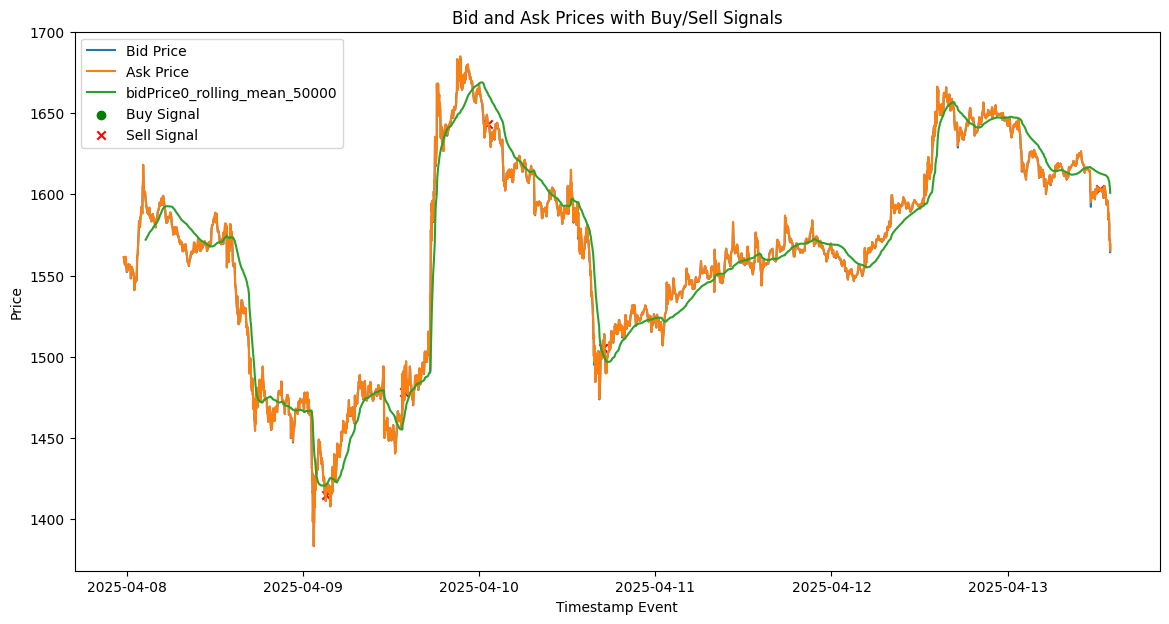

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Sample every 1000th row
sampled_df = output_df.iloc[::1000, :]

# Create the plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=sampled_df, x='timestampEvent', y='bidPrice0', label='Bid Price')
sns.lineplot(data=sampled_df, x='timestampEvent', y='askPrice0', label='Ask Price')
sns.lineplot(data=sampled_df, x='timestampEvent', y='bidPrice0_rolling_mean_5000', label='bidPrice0_rolling_mean_5000')
sns.lineplot(data=sampled_df, x='timestampEvent', y='bidPrice0_rolling_mean_50000', label='bidPrice0_rolling_mean_50000')

# Add green and red dots for actions
buy_signals = sampled_df[sampled_df[f'{action.name}_cash_action'] > 0]
sell_signals = sampled_df[sampled_df[f'{action.name}_cash_action'] < 0 ]

plt.scatter(buy_signals['timestampEvent'], buy_signals['askPrice0'], color='green', label='Buy Signal', marker='o')
plt.scatter(sell_signals['timestampEvent'], sell_signals['askPrice0'], color='red', label='Sell Signal', marker='x')

plt.xlabel('Timestamp Event')
plt.ylabel('Price')
plt.title('Bid and Ask Prices with Buy/Sell Signals')
plt.legend()
plt.show()
# 


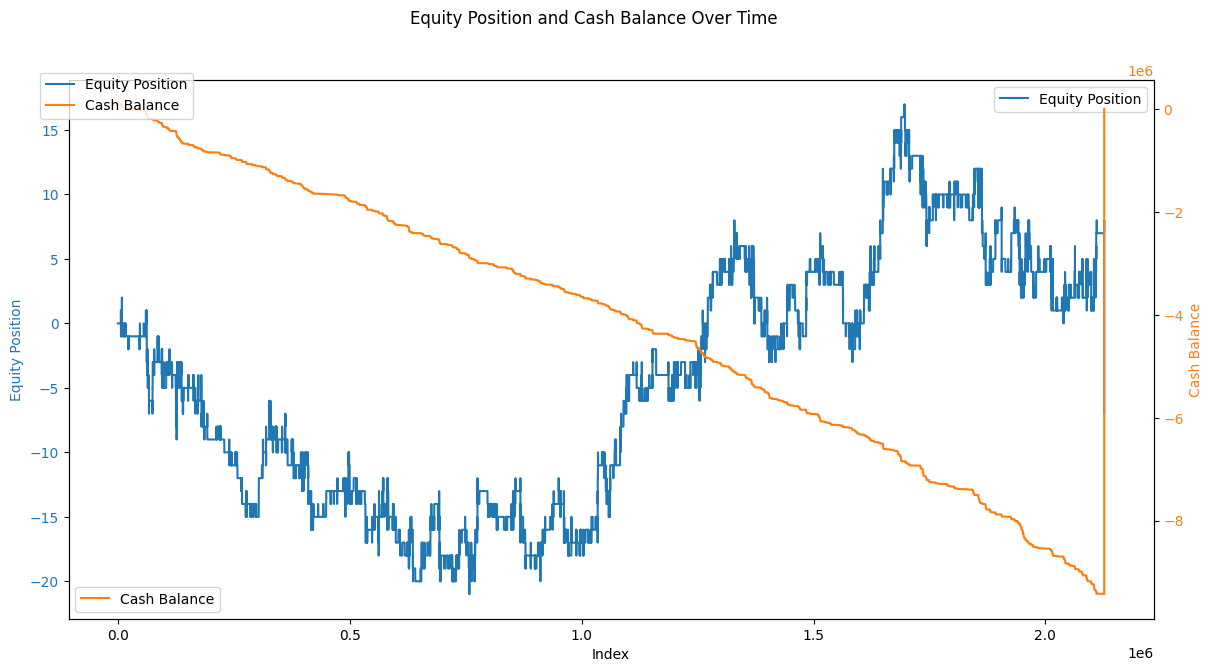

In [5]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Equity Position on the first y-axis
ax1.set_xlabel('Index')
ax1.set_ylabel('Equity Position', color='tab:blue')
sns.lineplot(data=output_df, x=output_df.index, y=f'{action.name}_equity_position', label='Equity Position', ax=ax1, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for Cash Balance
ax2 = ax1.twinx()
ax2.set_ylabel('Cash Balance', color='tab:orange')
sns.lineplot(data=output_df, x=output_df.index, y=f'{action.name}_cash_balance', label='Cash Balance', ax=ax2, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add title and legend
fig.suptitle('Equity Position and Cash Balance Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()

In [6]:
# Summarize the backtest results
starting_cash = strategy.starting_cash
ending_cash = output_df[f'{action.name}_cash_balance'].iloc[-1]
number_of_trades = len(output_df[output_df[f'{action.name}_cash_action'] != 0])
frequency_of_trades = len(output_df) / number_of_trades # Ticks per trade
mro = (ending_cash - starting_cash) / starting_cash

summary = {
    "Starting Cash": starting_cash,
    "Ending Cash": ending_cash,
    "Number of Trades": number_of_trades,
    "Frequency of Trades": frequency_of_trades,
    "MRO": mro
}

print("Backtest Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")


Backtest Summary:
Starting Cash: 100000.0
Ending Cash: 11008.9
Number of Trades: 6111
Frequency of Trades: 348.0232367861234
MRO: -0.889911


In [7]:
play_df = output_df[499:550]

In [8]:
output_df.loc[739:742, ['bidPrice0_rolling_mean_50_over_500_action', 'bidPrice0_rolling_mean_50_over_500_cash_action', 'bidPrice0_rolling_mean_50_over_500_cash_balance', 'bidPrice0_rolling_mean_50_over_500_equity_position']]

KeyError: "None of [Index(['bidPrice0_rolling_mean_50_over_500_action',\n       'bidPrice0_rolling_mean_50_over_500_cash_action',\n       'bidPrice0_rolling_mean_50_over_500_cash_balance',\n       'bidPrice0_rolling_mean_50_over_500_equity_position'],\n      dtype='object')] are in the [columns]"

In [9]:
output_df.loc[790:900, ['bidPrice0_rolling_mean_50_over_500_action', 'bidPrice0_rolling_mean_50_over_500_cash_action', 'bidPrice0_rolling_mean_50_over_500_cash_balance', 'bidPrice0_rolling_mean_50_over_500_equity_position']]

,bidPrice0_rolling_mean_50_over_500_action,bidPrice0_rolling_mean_50_over_500_cash_action,bidPrice0_rolling_mean_50_over_500_cash_balance,bidPrice0_rolling_mean_50_over_500_equity_position
790,1,-1577.0,-78358.0,61
791,1,-1576.9,-79934.9,62
792,1,-1576.9,-81511.8,63
793,1,-1576.4,-83088.2,64
794,1,-1576.5,-84664.7,65
...,...,...,...,...
896,1,-1577.5,-245565.1,167
897,1,-1577.5,-247142.6,168
898,1,-1577.5,-248720.1,169
899,1,-1577.5,-250297.6,170


In [14]:
columns = {"column0": "bid0", "column1": "bid1"}
pd_expression="data[column0].rolling(window=500).mean() - data[column1].rolling(window=500).mean().shift(-1)"

for key, value in columns.items():
    pd_expression = pd_expression.replace(key, f"'{value}'")

print(pd_expression)


data['bid0'].rolling(window=500).mean() - data['bid1'].rolling(window=500).mean().shift(-1)
